In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
import random
import os
from tensorflow.python.framework import ops
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import pickle
import matplotlib.gridspec as gridspec
from IPython.display import Image, display

/home/dheeraj/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dheeraj/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dheeraj/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/dheeraj/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:5

In [2]:
#tf.reset_default_graph()

In [3]:
def show_images(images):
    images = np.reshape(images, [images.shape[0],-1])
    sqrt_n = int(np.ceil(np.sqrt(images.shape[0])))
    sqrt_img = int(np.ceil(np.sqrt(images.shape[1])))
    
    fig = plt.figure(figsize = (sqrt_n, sqrt_n))
    gs = gridspec.GridSpec(sqrt_n, sqrt_n)
    gs.update(wspace = 0.05, hspace = 0.05)
    
    for i, img in enumerate(images):
        ax  = plt.subplot(gs[i])
        plt.axis('Off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.imshow(img.reshape([sqrt_img, sqrt_img]))
        
    return

In [4]:

data="/media/dheeraj/9A26F0CB26F0AA01/WORK/jupyter_files/kagglecatsanddogs_3367a/PetImages"
Categories=["Dog", "Cat"]


(375, 500)


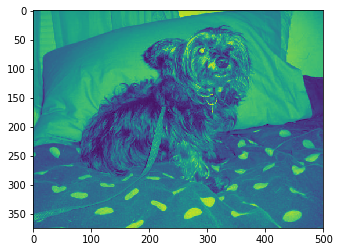

In [5]:


#config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)

for category in Categories:
    
     # here we need to join the path of the directories of dogs and cats together
    path=os.path.join(data, category)
    
    for img in os.listdir(path):
        img_array=cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE) #converting the photo to greyscale
        print(np.shape(img_array))
        plt.imshow(img_array)
        plt.show()
        break
    break    
    
    

In [6]:
print(img_array)

[[117 117 119 ... 133 132 132]
 [118 117 119 ... 135 134 134]
 [119 118 120 ... 137 136 136]
 ...
 [ 79  74  73 ...  80  76  73]
 [ 78  72  69 ...  72  73  74]
 [ 74  71  70 ...  75  73  71]]


In [7]:
print(img_array.shape)


(375, 500)


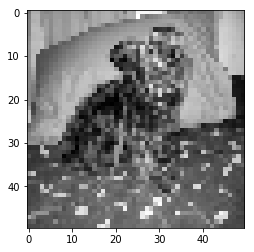

(50, 50)


In [8]:
#The sizes of all the photos are different. 
# changing the size of every photo to a constant size to work for CNN

img_size= 50

new_images=cv2.resize(img_array, (img_size, img_size), cv2.IMREAD_GRAYSCALE)  # size of image is 100*100
plt.imshow(new_images, cmap='gray')
plt.show()
print(new_images.shape)

In [9]:
# X and Z will have real data and generated data respetivel
X = tf.placeholder(tf.float32, shape = [None, img_size*img_size])
Z = tf.placeholder(tf.float32, shape = [None, 100])

In [10]:
#print(len(training_data))
#totsize = len(training_data)
#print(totsize)

In [11]:
training_data=[]
def create_training_data():
    for category in Categories:
    
        # here we need to join the path of the directories of dogs and cats together
        path=os.path.join(data, category)

        #here we create catogories for the classes for comparison
        class_num=Categories.index(category)

        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path, img), 0)  
                new_images=cv2.resize(img_array, (img_size, img_size))  # size of image is 100*100
                training_data.append([new_images, class_num])
                #print(class_num)
            except Exception as e:
                pass

create_training_data()      


In [12]:
import numpy as np
print(len(training_data))
print(np.shape(training_data))
print(np.shape(training_data[0]))

7527
(7527, 2)
(2,)


In [13]:
random.shuffle(training_data)

(7527, 50, 50)
(7527, 50, 50, 1)
(7527, 2500)


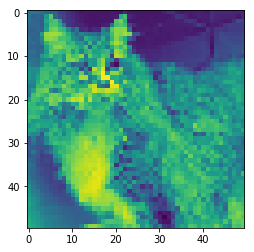

In [14]:
xx=[]
yy=[]

for features, label in training_data:
    xx.append(features)
    yy.append(label)
plt.imshow(xx[0])

#print(yy)
print(np.shape(xx))
#converting the pixels into a numpy array
#-1 for including all the images
# img_size for the image size that we have taken
# 1 since the image has been taken in a grayscale format
#print(xx)
xx=np.array(xx).reshape([-1, img_size, img_size, 1])
x_main = xx.reshape([-1, img_size * img_size])
#x_main= np.array(xx).reshape(-1, img_size*img_size)
print(xx.shape)
print(x_main.shape)

In [15]:
a=(x_main.shape[0])
i=np.random.permutation(a)
x_train=x_main[i]
print(x_train.shape)

(7527, 2500)


In [16]:
#normalising the data by dividing it by the maximum value of pixel

#x_train = x_train/255.0
totsize = len(training_data)
print(totsize)

7527


In [17]:
def generator(z):
    
    with tf.variable_scope("generator", reuse = tf.AUTO_REUSE):
        init = tf.contrib.layers.xavier_initializer()
        h1 = tf.layers.dense(inputs = z, units = 64, activation = tf.nn.relu, kernel_initializer = init, 
                            use_bias = True)
        
        h2 = tf.layers.dense(inputs = h1, units = 128, activation = tf.nn.relu, kernel_initializer =init,
                             use_bias = True)
        
        h3 = tf.layers.dense(inputs = h2, units = 256, activation = tf.nn.relu, kernel_initializer =init,
                             use_bias = True)
        
        out = tf.layers.dense(inputs = h3, units = img_size * img_size, activation = tf.nn.tanh, kernel_initializer =init,
                             use_bias = True)
        
        return out
   

In [18]:
 
def discriminator(x):
    
    print("hello world")
    with tf.variable_scope("discriminator", reuse = tf.AUTO_REUSE):
        init = tf.contrib.layers.xavier_initializer()
        h1 = tf.layers.dense(inputs = x, units = 64, activation = tf.nn.relu, kernel_initializer= init, 
                             use_bias = True)
        
        h2 = tf.layers.dense(inputs = h1, units = 128, activation = tf.nn.relu, kernel_initializer= init, 
                             use_bias = True)
        
        
        h3 = tf.layers.dense(inputs = h2, units = 256, activation = tf.nn.relu, kernel_initializer= init, 
                             use_bias = True)
        
        logits  = tf.layers.dense(inputs = h3, units = 1,kernel_initializer= init,  use_bias = True)
        
        return logits
    
    
    
def discriminator_copy(x):
    with tf.variable_scope("discriminator", reuse = False):
        init = tf.contrib.layers.xavier_initializer()
        h1 = tf.layers.dense(inputs = x, units = 64, activation = tf.nn.relu, kernel_initializer= init, 
                             use_bias = True)
        
        h2 = tf.layers.dense(inputs = h1, units = 128, activation = tf.nn.relu, kernel_initializer= init, 
                             use_bias = True)
        
        
        h3 = tf.layers.dense(inputs = h2, units = 256, activation = tf.nn.relu, kernel_initializer= init, 
                             use_bias = True)
        
        logits  = tf.layers.dense(inputs = h3, units = 1,kernel_initializer= init,  use_bias = True)
        
        return logits
        
        

In [19]:
def sample_Z(r, c):
    return np.random.uniform(-1., 1., size = [r, c])


In [20]:
G_sample = generator(Z)
#G_sample  = np.array(G_sample).reshape([-1, img_size, img_size, 1])
print(G_sample.shape, X.shape)

(?, 2500) (?, 2500)


In [21]:
logits_real = discriminator(X)


hello world


In [22]:
logits_fake = discriminator(G_sample)


hello world


In [23]:
# now calculating the loss fucntion for both generator and discriminator

#now for D_loss_real, we have taken labels as tf.ones_like
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(logits_real),
                                                                     logits = logits_real))

# for D_loss_fake, we have taken the labels as tf.zeros_like, because it needs to reduce the output 
#generated by the generator
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.zeros_like(logits_fake),
                                                                     logits = logits_fake))

D_loss = D_loss_real + D_loss_fake

#For G_loss, we have taken labels  as tf.ones_like, this is because the generator needs to maximize itself
#with respect to the discriminator
G_loss= tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(logits_fake),
                                                                     logits = logits_fake))

In [24]:
#Actual loss code for the equations but above is the better version of it

D_real = tf.nn.sigmoid(logits_real)
D_fake = tf.nn.sigmoid(logits_fake)

D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))

G_loss = -tf.reduce_mean(tf.log(D_fake))


In [25]:
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')


In [34]:
D_solver = tf.train.AdamOptimizer(learning_rate = 1e-4, beta1 = 0.5).minimize(D_loss, var_list = D_vars)
G_solver = tf.train.AdamOptimizer(learning_rate = 1e-4, beta1 = 0.5).minimize(G_loss, var_list = G_vars)


Initial generated images
[[-0.02564362 -0.00559491  0.04286429 ...  0.03769344 -0.08480328
   0.01089293]
 [ 0.00290464 -0.0749167   0.03719726 ...  0.03276476 -0.13939999
  -0.04769369]
 [ 0.02046018  0.00297908  0.03882067 ... -0.0067805  -0.08083774
  -0.01200742]
 ...
 [-0.04866386  0.02382417  0.03296357 ...  0.01960993 -0.03533509
  -0.01102658]
 [ 0.0009208  -0.07238178 -0.00281917 ... -0.04477382 -0.09308597
  -0.04006871]
 [ 0.04563114 -0.04145782  0.05033549 ...  0.02392233 -0.06536206
  -0.04362697]]


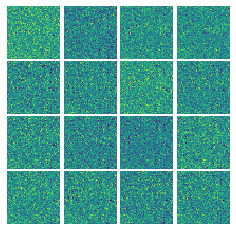

In [35]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
print("Initial generated images")
samples = sess.run(G_sample,feed_dict={Z: sample_Z(128, 100)})
print(samples)
fig = show_images(samples[:16])
plt.show()
print()

In [36]:
#tf.layers.dense?

In [37]:
def createBatch(start,batchSize):
    batchAddr=trainData[start:start+batchSize]
    batch_y=trainLabel[start:start+batchSize]
    #print(batchAddr)
    return batchAddr,batch_y


def one_hot(raw_labels):
    import numpy as np
    raw_labels=np.array(raw_labels,np.int32)
    n_values = np.max(raw_labels) + 1
    onehotDash=np.eye(n_values)[raw_labels]
    onehot=np.reshape(onehotDash,(len(raw_labels),2))##we reshape from a 3D matrix as built by default using eye function to a 2D array
    print(onehot.shape)
    return onehot

In [38]:
onehot_train=one_hot(yy)

(7527, 2)


In [39]:
    #x, _ = createBatch(hello*128, 128)
batchsize = 128
num_batch = int(totsize / (batchsize))
print(num_batch)

58


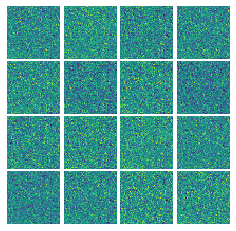


number of batches is as follows : 58
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
number of batches is as follows : 58
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(

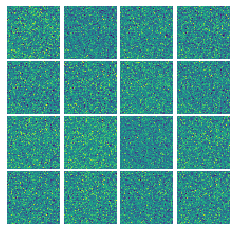


number of batches is as follows : 58
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
number of batches is as follows : 58
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(

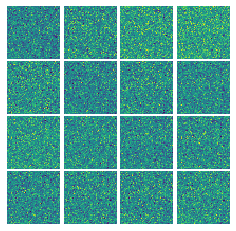


number of batches is as follows : 58
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
number of batches is as follows : 58
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(

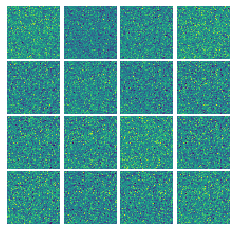


number of batches is as follows : 58
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
number of batches is as follows : 58
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(

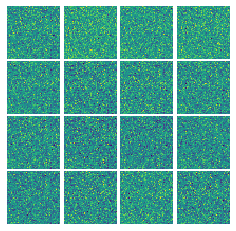


number of batches is as follows : 58
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
number of batches is as follows : 58
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(

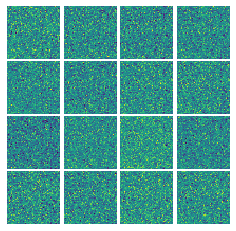


number of batches is as follows : 58
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
number of batches is as follows : 58
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(

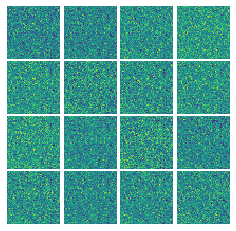


number of batches is as follows : 58
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
number of batches is as follows : 58
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(

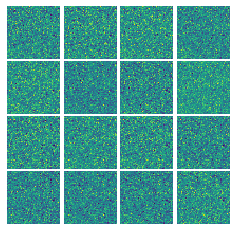


number of batches is as follows : 58
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
number of batches is as follows : 58
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(

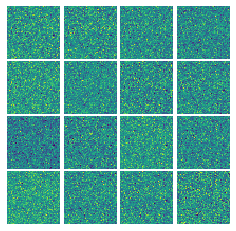


number of batches is as follows : 58
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
number of batches is as follows : 58
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(

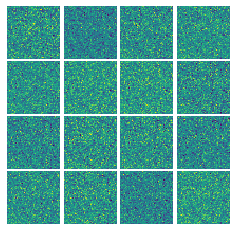


number of batches is as follows : 58
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
number of batches is as follows : 58
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(128, 2500)
(

In [40]:
for it in range(100):
    
    #batch_x,batch_y=createBatch(hello*batch_size, batch_size)
    # this loop is for shoing the generated images over iterations
    if(it%10 == 0):
        samples = sess.run(G_sample, feed_dict = {Z: sample_Z(batchsize, 100)})
        fig = show_images(samples[:16])
        plt.show()
        print()
    
        # batch size has been defines to 128
    #x, _ = createBatch(hello*128, 128)
    print("number of batches is as follows : {}" .format(num_batch))
    for i in range(num_batch):
        #_=onehot_train[i*batchsize:(i+1)*batchsize,:]
        x=x_train[i*batchsize:(i+1)*batchsize,:]
        print(x.shape)

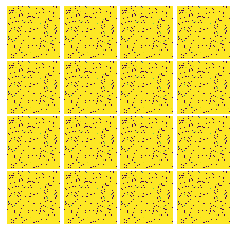


bhai kaunsi iteration chal rahi hai ? : 0
iter : 0
D loss : 0.0007611
G loss : 7.203

bhai kaunsi iteration chal rahi hai ? : 1
bhai kaunsi iteration chal rahi hai ? : 2
bhai kaunsi iteration chal rahi hai ? : 3
bhai kaunsi iteration chal rahi hai ? : 4
bhai kaunsi iteration chal rahi hai ? : 5
bhai kaunsi iteration chal rahi hai ? : 6
bhai kaunsi iteration chal rahi hai ? : 7
bhai kaunsi iteration chal rahi hai ? : 8
bhai kaunsi iteration chal rahi hai ? : 9
bhai kaunsi iteration chal rahi hai ? : 10
bhai kaunsi iteration chal rahi hai ? : 11
bhai kaunsi iteration chal rahi hai ? : 12
bhai kaunsi iteration chal rahi hai ? : 13
bhai kaunsi iteration chal rahi hai ? : 14
bhai kaunsi iteration chal rahi hai ? : 15
bhai kaunsi iteration chal rahi hai ? : 16
bhai kaunsi iteration chal rahi hai ? : 17
bhai kaunsi iteration chal rahi hai ? : 18
bhai kaunsi iteration chal rahi hai ? : 19
bhai kaunsi iteration chal rahi hai ? : 20
bhai kaunsi iteration chal rahi hai ? : 21
bhai kaunsi iterati

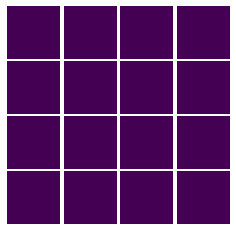


bhai kaunsi iteration chal rahi hai ? : 100
iter : 100
D loss : nan
G loss : nan

bhai kaunsi iteration chal rahi hai ? : 101
bhai kaunsi iteration chal rahi hai ? : 102
bhai kaunsi iteration chal rahi hai ? : 103
bhai kaunsi iteration chal rahi hai ? : 104
bhai kaunsi iteration chal rahi hai ? : 105
bhai kaunsi iteration chal rahi hai ? : 106
bhai kaunsi iteration chal rahi hai ? : 107
bhai kaunsi iteration chal rahi hai ? : 108
bhai kaunsi iteration chal rahi hai ? : 109
bhai kaunsi iteration chal rahi hai ? : 110
bhai kaunsi iteration chal rahi hai ? : 111
bhai kaunsi iteration chal rahi hai ? : 112
bhai kaunsi iteration chal rahi hai ? : 113
bhai kaunsi iteration chal rahi hai ? : 114
bhai kaunsi iteration chal rahi hai ? : 115
bhai kaunsi iteration chal rahi hai ? : 116
bhai kaunsi iteration chal rahi hai ? : 117
bhai kaunsi iteration chal rahi hai ? : 118
bhai kaunsi iteration chal rahi hai ? : 119
bhai kaunsi iteration chal rahi hai ? : 120
bhai kaunsi iteration chal rahi hai ?

KeyboardInterrupt: 

In [42]:
for it in range(10000):
    
    #batch_x,batch_y=createBatch(hello*batch_size, batch_size)
    # this loop is for shoing the generated images over iterations
    if(it%100 == 0):
        samples = sess.run(G_sample, feed_dict = {Z: sample_Z(batchsize, 100)})
        fig = show_images(samples[:16])
        plt.show()
        print()
    print("bhai kaunsi iteration chal rahi hai ? : {}".format(it))
        # batch size has been defines to 128
    #x, _ = createBatch(hello*128, 128)
    num_batch = int(totsize / (batchsize))
    for i in range(num_batch):
        #_=onehot_train[i*batchsize:(i+1)*batchsize,:]

            
        x=x_main[i*batchsize:(i+1)*batchsize,:]
        #print(x.shape)
        #x, _ = nextbatch(batch_i)
        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict = {X: x, Z : sample_Z(batchsize, 100)})
        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict = {Z: sample_Z(batchsize, 100)})

    if(it%100 == 0):
        print("iter : {}".format(it))
        print("D loss : {:.4}".format(D_loss_curr))
        print("G loss : {:.4}".format(G_loss_curr))
        print()
